# Intracellular Binding Site Analysis

In [53]:
import os,sys,inspect

path_to_project="/home/martalo/Documentos/TFM/GPCR_variants"
resultspath="/home/martalo/Documentos/TFM/GPCR_variants/Results/studied_GPCR_vars"
dictpath="/home/martalo/Documentos/TFM/GPCR_variants/Results/gpcr_to_pdb/"
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install bioservices
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install xlrd

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import urllib

import mdtraj as md
import itertools
from htmd.ui import *
from htmd.config import config
config(viewer='webgl')
import requests
import os
from matplotlib.ticker import FormatStrFormatter

!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import csv
import re

import analysis_common_functions as anls

In [54]:
# First read the data file:
# build a data frame
varDataFile="PTM_IMPACT/vars_A_impact_ptm_role4.csv"
df = pd.read_csv(os.path.join(resultspath,varDataFile), delimiter =";") 
print(df.head()) 

   Number               Family                       Subamily  \
0       0  Aminergic receptors  5-Hydroxytryptamine receptors   
1       1  Aminergic receptors  5-Hydroxytryptamine receptors   
2       2  Aminergic receptors  5-Hydroxytryptamine receptors   
3       3  Aminergic receptors  5-Hydroxytryptamine receptors   
4       4  Aminergic receptors  5-Hydroxytryptamine receptors   

                              Name  Short Uniprot ID Uniprot entry  \
0  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
1  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
2  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
3  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   
4  5-hydroxytryptamine receptor 1A  HTR1A     P08908   5ht1a_human   

                                      Struc             gene         varID  \
0  [Model]: 6G79 (Active) & 4IAQ (Inactive)  ENSG00000178394   rs752821044   
1  [Model]: 6G79 (Active) & 4IAQ

In [55]:
# IF THE DF FILE HAS CHANGE THE NAME OF THE GPCRS YOU SHOULD CHANGE IT ALSO IN analysis_common_functions!

# y axis, names of the class A receptors. Ex: '5-hydroxytryptamine receptor 1a (HTR1A)'
all_gpcrs_axes_set=set()
long=df['Name'].tolist()
short=df['Short'].tolist()
for l, s in list(zip(long, short)):    
    all_gpcrs_axes_set.add("%s (%s)" % (l,s))
all_gpcrs_axes_list=list(all_gpcrs_axes_set)

# order y-axis by alphabeticall order
all_gpcrs_axes=sorted(all_gpcrs_axes_list, key=str.lower)
print('Total number of GPCRs(rows of heatmap): ',len(all_gpcrs_axes))
# print(all_gpcrs_axes)

Total number of GPCRs(rows of heatmap):  287


## 1. Score analysis
Define the data frame, GPCR in the y axis, positions in the x axis. The colors will be: pale (score 0) for bening MVs, orange (1) for possibly damaging, red (2) damaging, and finally, white (3) for the ones that do not have information.

In [56]:
# x axis, positions of the residues that form the IBS of class A
inner_binding_site_gnum=['1x59', '1x60', '12x48', '12x49', '12x50', '12x51', '2x34', '2x35', '2x36', '2x37', '2x38', '2x39', '2x40', '2x43', '3x49', '3x50', '3x53', '3x54', '3x55', '3x56', '34x50', '34x51', '34x52', '34x53', '34x54', '34x55', '34x56', '34x57', '4x39', '4x40', '5x61', '5x64', '5x65', '5x66', '5x67', '5x68', '5x69', '5x71', '5x72', '5x73', '5x74', '5x75', '6x24', '6x25', '6x26', '6x28', '6x29', '6x30', '6x32', '6x33', '6x36', '6x37', '6x38', '6x40', '7x53', '7x55', '7x56', '8x47', '8x48', '8x49']


In [57]:
# build a data frame to display the heatmaps
gpcr_ibspos=anls.build_dataFrame(inner_binding_site_gnum)
# cols are the residues of the intracellular binding site of all GPCRs, the rows are the names
# of the class A GPCRs
# initially all the values of the matrix set to 3 (that will correspond to the cells without data)

# Now we have to fill in the df with 0,1,2 depending on the impact score:
# gpcr_ibspos[ibspos][gpcrname]= 0,1 or 2
anls.fill_in_dataFrame(gpcr_ibspos, inner_binding_site_gnum, df)

#display the result as a heatmap
# anls.heatmap_only(gpcr_ibspos)

Now we will add the option of number of variants order and the sum by column and row. First, sum by row, order by number of varinats or not. We will do the separation score 1 and score 2. 

In [58]:
# Sum variants of each GPCR
# Change the number to display the sum of possibly damaging (1) or damaging (2)
# Add 'False' (4th element)  to hide the heatmap, otherwise the barplot will appear below
# Add 'True' (5th element) if you want to order the columns by increasing number of MVs

# anls.heatmap_horizontal_sum(gpcr_ibspos,inner_binding_site_gnum,2, False)

Now we will put in the same barplot both score 1 and score 2. Without the option to order by incresing number of variants.

ADD THE OPTION TO SORT! If needed, by now is only alphabetically

In [59]:
# Sum variants of each GPCR, barplot below heatmap, with damaging (red) and possibly damaging (orange)
# anls.heatmap_horizontal_sum_mixed(gpcr_ibspos)

Now we will add the sum by position, by column.

In [60]:
# add True as 3rd parameter to display the barplot downwards
# anls.heatmap_vert_sum_mixed(gpcr_ibspos,inner_binding_site_gnum)

## 2. Disease Analysis

In [61]:
gpcr_ibspos_dis=anls.build_dataFrame(inner_binding_site_gnum,0)
anls.fill_in_dataFrame_diseases(gpcr_ibspos_dis,inner_binding_site_gnum,df)
# anls.heatmap_only_diseases(gpcr_ibspos_dis)

+ Variant in ADRB3, rs4994,1x59 is related with 65 diseases: circulatory, respiratory, methabolic, but not mental illnesses. BENING (changed).
+ In MC1R, rs1805007,34x52: with 25 diseses, hair skin problems, not mental illness. DAMAGING (changed).

### 2.1 Diasese heatmap compact

In [62]:
def computeDimensions(listGnum,df,parameter,yaxis=all_gpcrs_axes):
    '''Print GPCRs and Pos that have dis/PTM (depending on the parameter)
    return a list len of GPCRs and len of pos'''
    dim=[]
    gpcrDis=set()
    posDis=set()
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), parameter].tolist()
            if len(disList)>0:
                if 'Yes' in disList or 'yes' in disList:
                    print(ibspos, gpcr,disList)
                    gpcrDis.add(gpcr)
                    posDis.add(ibspos)
    print('Set of GPCrs and len',gpcrDis,len(gpcrDis))
    print('Set of positions and len',posDis,len(posDis))
    dim.append(len(gpcrDis))
    dim.append(len(posDis))
    return dim

# dimension=computeDimensions(inner_binding_site_gnum,df,'disease')
# dimension=[44, 46]
gpcrsDis=['PTGIR', 'AGTR1', 'P2RY2', 'LPAR3', 'ADRA1A', 'OPN1LW', 'AVPR1B', 'ADRB3', 'MC4R', 'CXCR4', 'MRGPRX1', 'PROKR2', 'AVPR2', 'CNR2', 'MTNR1B', 'OPN2', 'TBXA2R', 'F2RL1', 'TRHR', 'KISS1R', 'LGR4', 'OPRM1', 'CYSLTR2', 'FFAR4', 'FSHR', 'LGR5', 'MC3R', 'MC1R', 'P2RY12', 'MRGPRX4', 'ADRA2B', 'LPAR2', 'ADORA2B', 'PTAFR', 'GNRHR', 'TSHR', 'EDNRA', 'GPR1', 'CCR5', 'CXCR2', 'MC2R', 'TACR2', 'UTS2R', 'CXCR6']
# posDis=['5x65', '5x64', '12x48', '4x39', '6x25', '3x53', '2x40', '12x49', '5x66', '34x57', '1x59', '4x40', '6x40', '6x26', '3x50', '34x56', '34x52', '34x51', '5x73', '6x37', '6x36', '5x67', '34x53', '6x29', '7x53', '5x72', '12x51', '1x60', '3x54', '8x47', '7x56', '2x38', '34x50', '5x61', '3x55', '3x56', '12x50', '6x32', '7x55', '34x55', '8x49', '6x38', '6x28', '2x43', '5x68', '6x30']
# posDis.sort()
posDis=['1x59', '1x60', '12x48', '12x49', '12x50', '12x51','2x38', '2x40', '2x43','3x50', '3x53', '3x54', '3x55', '3x56','34x50', '34x51', '34x52', '34x53', '34x55', '34x56', '34x57','4x39', '4x40', '5x61', '5x64', '5x65', '5x66', '5x67', '5x68', '5x72', '5x73', '6x25', '6x26', '6x28', '6x29', '6x30', '6x32', '6x36', '6x37', '6x38', '6x40', '7x53', '7x55', '7x56', '8x47', '8x49']

# print(posDis)

In [63]:
def fill_in_dataFrame_diseasesOnly(dataFrame, listGnum, df,disPos,disGpcr,yaxis=all_gpcrs_axes):
    '''Fill in the df with 0,1,2,.. depending on the number of related diseases.
    MAYBE tune with T/F to only the vars with impact score 2'''
    p=re.compile(".*\((\w*)\)")
    difNums=set()
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            if ibspos in disPos and gpcr in disGpcr:
                value=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'related_diseases'].tolist()
                disList=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), 'disease'].tolist()
                if len(disList)>0:
                    if 'Yes' in disList or 'yes' in disList:
                        dis='Yes'#Yes/No
                    else:
                        dis='No'
                else:
                    dis='No'
                if len(value)>0:#if there are matches, non-void list   
                    numValues=[x for x in value if x>=0]#avoid NaN
                    if numValues:
                        valueOk=max(numValues)
#                         print(gpcr, ibspos, value, valueOk)
    #                     print('Max value',valueOk)
                if dis=='Yes': 
                    dataFrame[ibspos][gpcr]=valueOk # we will take tha max in case there
                    difNums.add(valueOk)
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
                    # are two rows matching
                    #  if value equal to NaN, te cell will be zero
    return difNums

disOnly=pd.DataFrame(columns=posDis,index=gpcrsDis).fillna(value=-5)# -5 to see differences
difNumsResDis=fill_in_dataFrame_diseasesOnly(disOnly,inner_binding_site_gnum,df,posDis,gpcrsDis)
# anls.heatmap_only_diseases(disOnly)

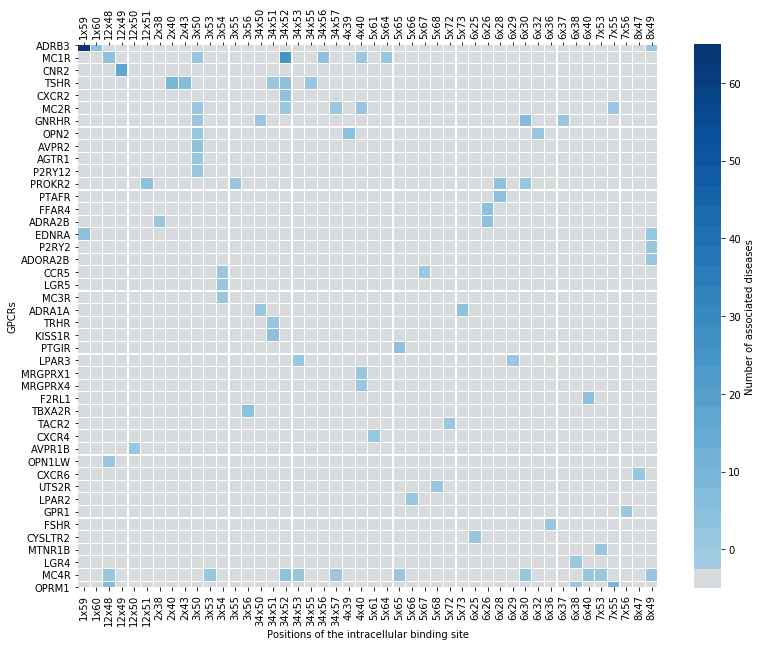

In [64]:
# heatmap and barplots graphs
def heatmap_only_diseases_nonZero(dataFrame,colorPalette='YlOrRd'):
    '''Plot the data frame than contains the color scale for the diseases'''
    color_map_sns=sns.color_palette(colorPalette,n_colors=40).as_hex()
    fig, ax = plt.subplots(figsize=(13,13))
    color_map=color_map_sns[14:]
    color_map.insert(0,'#d7dbdd')
#     color_map=['#d7dbdd','#a9cfe5', '#a1cbe2', '#99c7e0', '#8dc1dd', '#84bcdb', '#7ab6d9', '#71b1d7', '#66abd4','#2575b7', '#083674']

    
    ax2=sns.heatmap(dataFrame, cmap=color_map, linewidths=0.1, annot=False, 
        square=True,xticklabels=True, yticklabels=True,ax=ax,cbar=True,cbar_kws={"shrink": .77,'label':'Number of associated diseases'})
    
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
#     ax2.xaxis.set_ticks_position('top')
    
    plt.xticks(rotation=90) 
    
    ax2.set(xlabel='Positions of the intracellular binding site', ylabel='GPCRs')
    plt.show()
    return None

disOnlyClus=anls.cluster_df(disOnly)#cluster the dataframe
heatmap_only_diseases_nonZero(disOnlyClus,'Blues')
# disease/heatmapOnlyDis.png

In [65]:
print(sns.color_palette('Blues',n_colors=40).as_hex())

['#f2f8fd', '#eef5fc', '#e9f2fa', '#e4eff9', '#dfebf7', '#dae8f6', '#d6e5f4', '#d1e2f3', '#ccdff1', '#c7dcef', '#c1d9ed', '#b9d6ea', '#b0d2e7', '#a9cfe5', '#a1cbe2', '#99c7e0', '#8dc1dd', '#84bcdb', '#7ab6d9', '#71b1d7', '#66abd4', '#5fa6d1', '#57a0ce', '#4f9bcb', '#4695c8', '#3f8fc5', '#3989c1', '#3383be', '#2c7cba', '#2575b7', '#206fb4', '#1b69af', '#1562a9', '#115ca5', '#0c56a0', '#08509b', '#084990', '#084387', '#083c7d', '#083674']


In [66]:
# numer of associated diseases of the previous heatmap
difNumsResDis

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 16.0, 25.0, 65.0}

## 3. PTM

In [67]:
gpcr_ibspos_ptm=anls.build_dataFrame(inner_binding_site_gnum,0)
ptmValues=anls.fill_in_dataFrame_ptm(gpcr_ibspos_ptm,inner_binding_site_gnum,df)

# # if there is some PTM for this region
# if ptmValues:
#     anls.heatmap_only_ptm(gpcr_ibspos_ptm)

In [68]:
def count_ptms(df,pos):
    count=0
    for element in df[pos]:
        if element != 0:
            count+=1
    return count

print('Total PTMs in 5x69:')
print(count_ptms(gpcr_ibspos_ptm, '5x69'))

print('Total PTMs in 8x49:')
print(count_ptms(gpcr_ibspos_ptm, '8x49'))

Total PTMs in 5x69:
1
Total PTMs in 8x49:
1


First PTM in ADRA1A, pos 5x69, ModRes, but score 1. Second, in CHRM5, another ModRes in 8x49, score 2. Now we will see each type separatelly using the pink color scale:

In [69]:
# we need to build a dataframe with the PTM information
gpcr_ibspos_ptm_types=anls.build_dataFrame(inner_binding_site_gnum,0)
# we will fill each cell with different numeric values to represent in each PTM type
# 7 - ModRes   8 - Glyco   9 - Lipid  10 - DB
# from soft pink to fucsia


In [70]:
def fill_in_dataFrame_ptm_type(dataFrame, listGnum, typePTM, df,yaxis=all_gpcrs_axes):
    '''Fill in the dataFrame with 0,7,8,9,10 depending of the PTM type of the variant. 
    0 - noPTM   7 - ModRes   8 - Glyco   9 - Lipid  10 - DB '''
    ptmScores={'Modified Residue':7, 'Glycosylation':8, 'Lipidation':9, 'Disulfide Bond':10}
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            value=df.loc[(df.Short == gpcr) & (df.GPCRdb == ibspos), typePTM].tolist()   
#             print(value)
            if len(value)>=1 and type(value[0])!=float:#check that the cell is not void or nan
#                 print('In the if:',gpcrname,ibspos,value)
#                 print('ok')
                dataFrame[ibspos][gpcrname]=ptmScores[typePTM] # if it is a PTM position set 
                # the corresponding score
            #  if value equal to NaN or void, te cell will be zero
    return None

In [71]:
#modRes df
gpcr_ibspos_ptm_modRes=anls.build_dataFrame(inner_binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_ibspos_ptm_modRes,inner_binding_site_gnum,'Modified Residue',df)

#glyco df
gpcr_ibspos_ptm_glyco=anls.build_dataFrame(inner_binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_ibspos_ptm_glyco,inner_binding_site_gnum,'Glycosylation',df)

#lipid df
gpcr_ibspos_ptm_lipid=anls.build_dataFrame(inner_binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_ibspos_ptm_lipid,inner_binding_site_gnum,'Lipidation',df)

#DB df 
gpcr_ibspos_ptm_db=anls.build_dataFrame(inner_binding_site_gnum,0)
anls.fill_in_dataFrame_ptm_type(gpcr_ibspos_ptm_db,inner_binding_site_gnum,'Disulfide Bond',df)

In [72]:
print('Total MVs affecting modRes in 5x69:')
print(count_ptms(gpcr_ibspos_ptm_modRes, '5x69'))

print('Total  MVs affecting modRes in 8x49:')
print(count_ptms(gpcr_ibspos_ptm_modRes, '8x49'))

Total MVs affecting modRes in 5x69:
1
Total  MVs affecting modRes in 8x49:
1


['#EDEDF4', '#fcacd0']


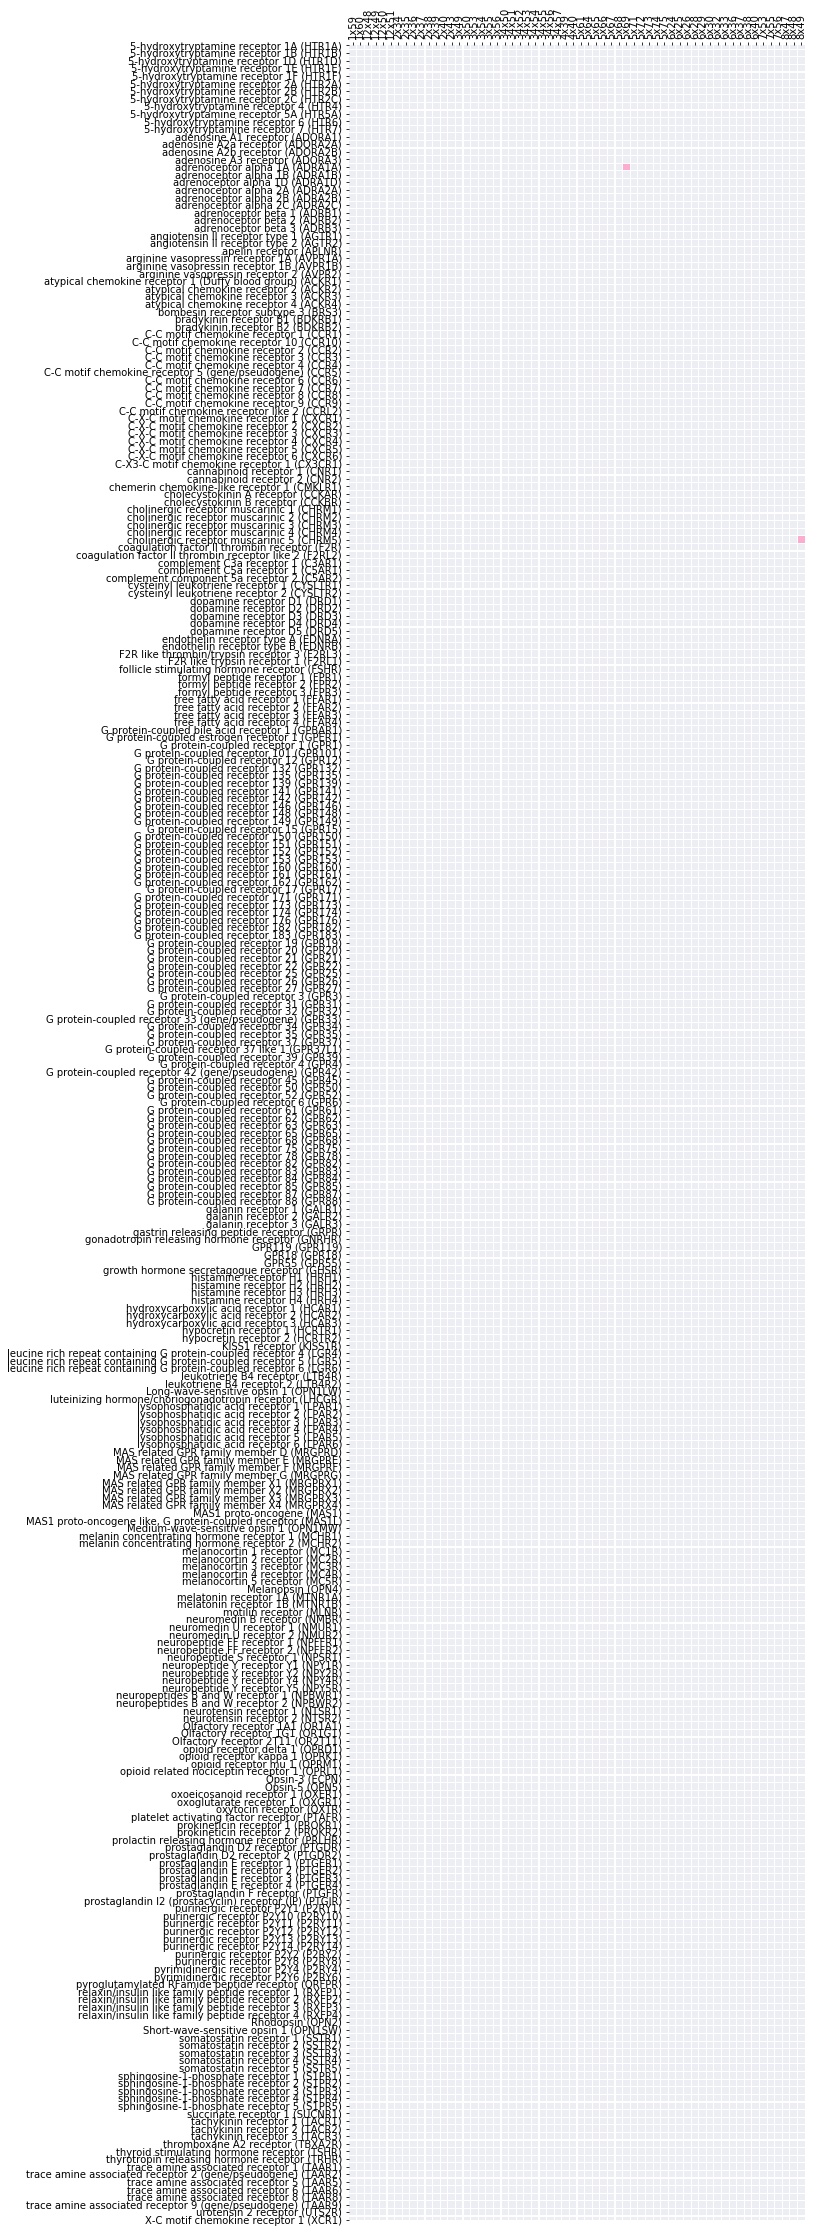

In [73]:
# merge the four df of the ptms in 'gpcr_bspos_ptm_types'
colorsPTMs=anls.fill_in_dataFrame_ptm_all_types(gpcr_ibspos_ptm_types,gpcr_ibspos_ptm_modRes,gpcr_ibspos_ptm_glyco,gpcr_ibspos_ptm_lipid,gpcr_ibspos_ptm_db,inner_binding_site_gnum)
anls.heatmap_only_ptm_all_types(gpcr_ibspos_ptm_types,colorsPTMs)

In [74]:
# heatmap only PTMs by color:

# dimension=computeDimensions(inner_binding_site_gnum,df,'PTM')

dimension=[2, 2]#GPCRs and pos with PTMs

gpcrsPTM=['ADRA1A', 'CHRM5']
PTMpos=[ '5x69','8x49']

In [75]:

def fill_in_dataFrame_PTMOnly(dataFrame,dfPTM,listGnum,PTMpos,PTMGpcr,yaxis=all_gpcrs_axes):
    ''' '''
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        for ibspos in listGnum: # iterate over positions
            if ibspos in PTMpos and gpcr in PTMGpcr:
                print(ibspos, gpcr)
                value=dfPTM[ibspos][gpcrname]#0,1,2,3,4
                print(value)
                if value>0:#if PTM   
#                     print(ibspos,gpcr,value)
                    dataFrame[ibspos][gpcr]=value # we will take tha max in case there
#                     print(ibspos, gpcrname,dataFrame[ibspos][gpcr])
    return None

#The df gpcr_bspos_ptm_types, values 0,1,2,3,4 -> noPTM, MR, Glyco, Lipid, DB

PTMOnly=pd.DataFrame(columns=PTMpos,index=gpcrsPTM).fillna(value=0)
difNumsResPTM=fill_in_dataFrame_PTMOnly(PTMOnly, gpcr_ibspos_ptm_types, inner_binding_site_gnum,PTMpos,gpcrsPTM)
PTMOnlyClus=anls.cluster_df(PTMOnly)#cluster the dataframe

5x69 ADRA1A
1
8x49 ADRA1A
0
5x69 CHRM5
0
8x49 CHRM5
1


['#fee7f1', '#fcacd0']


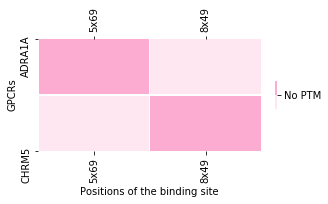

In [76]:
def heatmap_only_ptm_all_types(dataFrame,colors,x=5,y=5):
    '''Plot the data frame than contains the info of the PTM types in different pinks'''    
    colormap=["#fee7f1"]# zero values
    if 'pink1' in colors: #  were cells  with 7 -> 1 now
        colormap.append( "#fcacd0")#pink 1, soft
    if 'pink2' in colors:# there were cells with 8 -> 2
        colormap.append( "#f8589e")# pink 2
    if 'pink3' in colors: # there were cells with 9 -> 3
        colormap.append( "#d00d63")#pink 3 
    if 'pink4' in colors: # there were cells with 10 -> 4
        colormap.append( "#801f4a")#pink dark
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # no ptm  modRes  glyco   lipid   db
    # 0,         1,     2,      3,    4
    # white,  pink1, pink2,  pink3, pink4
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=True,square=True,xticklabels=True, yticklabels=True,ax=ax, cbar_kws={"shrink": .1})
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax2.collections[0].colorbar
    colorbar.set_ticks([0.5,1.5,2.5,3.5])
    colorbar.set_ticklabels(['No PTM','Modified residue', 'Glycosylation', 'Disulfide bond'])
    
    ax2.set(xlabel='Positions of the binding site', ylabel='GPCRs')
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.xticks(rotation=90) 
    plt.show()
    return None
heatmap_only_ptm_all_types(PTMOnlyClus,colorsPTMs)
# not valuable image

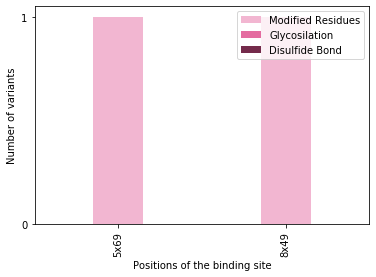

In [77]:
# vertical sum with the different PTMs
from matplotlib.ticker import MaxNLocator
def heatmap_vert_sum_ptms(dataFrame, listGnum, dbs=True):
    '''Horizontal barplot, sum each PTM type and plot them in different pinks'''
    gpcr_pos_count_bybs_all=dict(zip(listGnum,[0]*len(listGnum))) # DBs
    gpcr_pos_count_bybs_modRes=dict(zip(listGnum,[0]*len(listGnum))) # modRes
    gpcr_pos_count_bybs_glyco=dict(zip(listGnum,[0]*len(listGnum))) # glyco
    gpcr_pos_count_bybs_lipid=dict(zip(listGnum,[0]*len(listGnum))) # lipid

    for pos in gpcr_pos_count_bybs_all.keys():
        count_all=len([varval for varval in dataFrame[pos].values if varval==4 ])
        count_modRes=len([varval for varval in dataFrame[pos].values if varval==1])
        count_glyco=len([varval for varval in dataFrame[pos].values if varval==2])
        count_lipid=len([varval for varval in dataFrame[pos].values if varval==3])
        # store sums in the dictionaries position:sum of PTMs
        gpcr_pos_count_bybs_all[pos]=count_all
        gpcr_pos_count_bybs_modRes[pos]=count_modRes
        gpcr_pos_count_bybs_glyco[pos]=count_glyco
        gpcr_pos_count_bybs_lipid[pos]=count_lipid
    
    axisText='Positions of the binding site'
    # build dataframes
    gpcr_pos_count_bybs_all_df=pd.DataFrame(list(gpcr_pos_count_bybs_all.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_modRes_df=pd.DataFrame(list(gpcr_pos_count_bybs_modRes.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_glyco_df=pd.DataFrame(list(gpcr_pos_count_bybs_glyco.items()),
                          columns=[axisText,'Count'])
    gpcr_pos_count_bybs_lipid_df=pd.DataFrame(list(gpcr_pos_count_bybs_lipid.items()),
                          columns=[axisText,'Count'])    
    
    # representation upwards
    fig, ax = plt.subplots(figsize=(6,4))


    axB = sns.barplot(data=gpcr_pos_count_bybs_modRes_df , y="Count",x=axisText,color="#fcacd0",label="Modified Residues",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.set_xticklabels(labels=listGnum , rotation=90)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, 0.3)
    
    axB = sns.barplot(data=gpcr_pos_count_bybs_glyco_df , y="Count",x=axisText,color="#f8589e",label="Glycosilation",ax=ax)
    #axB.get_xaxis().set_visible(False)
    axB.yaxis.set_label_text("Number of variants")
    anls.change_width_v(axB, 0.3)
    
    if dbs:
        axB = sns.barplot(data=gpcr_pos_count_bybs_all_df, y="Count",x=axisText,color="#801f4a",label="Disulfide Bond",ax=ax)
        axB.set_xticklabels(labels=listGnum , rotation=90)
        #axB.get_xaxis().set_visible(False)
        axB.yaxis.set_label_text("Number of variants")
        #axB.invert_yaxis()
        anls.change_width_v(axB, 0.3)
    
    axB.yaxis.set_major_locator(MaxNLocator(integer=True)) # only integers in the y axis
    plt.legend()
    plt.show()
#     plt.savefig("/home/martalo/Documentos/TFM/GPCR_variants/Results/Intracel_Binding_site/ibs_count_positions.png")
    return None


# False as 3rd argument to avoid the max pics of the DB in the BS. 
# True as 4th to visualize the barplot downwards
heatmap_vert_sum_ptms(gpcr_ibspos_ptm_types,PTMpos)
#PTM/barplotPTM.png

## 4. 'Total' analysis (classA): score, disease, PTM
- If score 2: RED -> 2
- If score 1: ORANGE -> 1
- IF score 0: PALE -> 0
- If no-score: WHITE -> 3 
- If score 2 + disease related: color BLUE -> cell 4
- If score 2 + PTM: color PINK -> cell 5
- If score 2 + disease related + PTM: color BLACK -> cell 6

In [78]:
gpcr_ibspos_total=anls.build_dataFrame(inner_binding_site_gnum,0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_ibspos_total,gpcr_ibspos,gpcr_ibspos_dis,gpcr_ibspos_ptm,inner_binding_site_gnum)
# anls.heatmap_only_total(gpcr_ibspos_total, colorsToHeatmap)

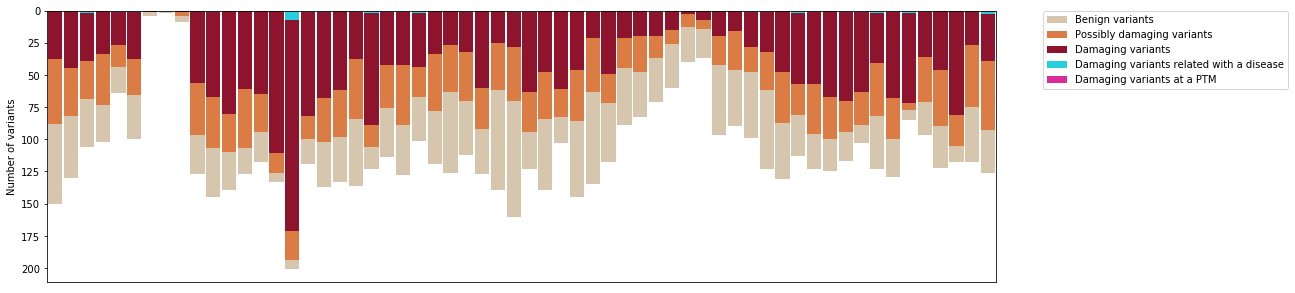

In [79]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_ibspos_total,inner_binding_site_gnum,True,True, False,False, True)
#classA/vertical.png

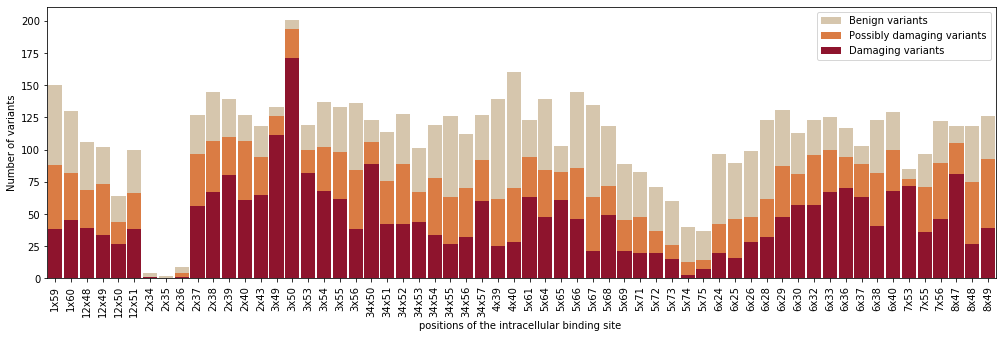

In [80]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_ibspos_total,inner_binding_site_gnum,False,False, True,True, True)
#classA/verticalUP.png

## 5. Only aminergic: score, disease, PTM

In [90]:
families=['5-Hydroxytryptamine receptors', 'Acetylcholine receptors (muscarinic)', 'Adrenoceptors', 'Dopamine receptors', 'Histamine receptors','Trace amine receptor']
aminergicSet=set()
aminergic=[]
aminergicLong=[]

dataFile="myprot_list_struc.csv"
with open(os.path.join(resultspath,dataFile),"r") as myvarfile:
    myvarread = csv.reader(myvarfile, delimiter=';') 
    for myrow in myvarread:
        score=0
        if myrow[0]=='Family':
            continue
        else:
            if myrow[0] in families:
                gpcr=myrow[1]+' ('+myrow[2]+')'
                aminergicSet.add(myrow[2])
                aminergicLong.append(gpcr)
myvarfile.close()    
aminergic=list(aminergicSet)     
# delete the ones without variant info: 
aminergicLong.remove('5-hydroxytryptamine receptor 5B, pseudogene (HTR5BP)')
len(aminergic)
print(len(aminergicLong))

36


In [114]:

gpcr_ibspos_total_amin_void=anls.build_dataFrame(inner_binding_site_gnum,0,aminergicLong)
gpcr_ibspos_total_amin_void

,1x59,1x60,12x48,12x49,12x50,12x51,2x34,2x35,2x36,2x37,...,6x36,6x37,6x38,6x40,7x53,7x55,7x56,8x47,8x48,8x49
5-hydroxytryptamine receptor 1A (HTR1A),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1B (HTR1B),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1D (HTR1D),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1E (HTR1E),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1F (HTR1F),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 2A (HTR2A),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 2B (HTR2B),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 2C (HTR2C),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 4 (HTR4),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 5A (HTR5A),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# filter aminergic
def filter_aminergic(dataFrame,aminDataFrame,aminList,listGnum,yaxis=all_gpcrs_axes):
    '''Build data frame with only the aminergic GPCRs'''
    p=re.compile(".*\((\w*)\)")
    for gpcrname in yaxis:# iteration over the GPCRs
        gpcr=re.search(p,gpcrname).group(1) # only the short name
        if gpcr in aminList:
#             print(gpcr)
            for ibspos in listGnum: # iterate over positions
                aminDataFrame[ibspos][gpcrname]=dataFrame[ibspos][gpcrname] # 0,1,2,3,4,5,6
    return aminDataFrame
# aminergic
gpcr_ibspos_total_amin=filter_aminergic(gpcr_ibspos_total,gpcr_ibspos_total_amin_void,aminergic,inner_binding_site_gnum)
# anls.heatmap_only_total(gpcr_ibspos_total_amin,'Positions of the intracellular binding site',"Class A GPCRs", colorsToHeatmap)
gpcr_ibspos_total_amin

,1x59,1x60,12x48,12x49,12x50,12x51,2x34,2x35,2x36,2x37,...,6x36,6x37,6x38,6x40,7x53,7x55,7x56,8x47,8x48,8x49
5-hydroxytryptamine receptor 1A (HTR1A),3,3,2,2,3,0,3,3,3,1,...,2,3,3,3,3,3,3,3,3,3
5-hydroxytryptamine receptor 1B (HTR1B),0,3,3,3,3,3,3,3,3,3,...,3,3,2,3,3,3,3,3,1,3
5-hydroxytryptamine receptor 1D (HTR1D),3,2,1,3,3,3,3,3,3,0,...,3,3,3,3,3,0,0,3,0,3
5-hydroxytryptamine receptor 1E (HTR1E),3,3,3,3,2,3,3,3,3,3,...,3,3,3,3,3,3,3,3,1,3
5-hydroxytryptamine receptor 1F (HTR1F),0,3,2,3,2,1,3,3,3,3,...,3,2,3,2,3,0,3,3,3,3
5-hydroxytryptamine receptor 2A (HTR2A),3,2,3,3,3,3,3,3,3,3,...,3,3,3,2,3,3,3,3,3,3
5-hydroxytryptamine receptor 2B (HTR2B),2,2,2,3,3,0,3,3,3,2,...,3,3,3,2,3,2,3,2,2,0
5-hydroxytryptamine receptor 2C (HTR2C),3,3,3,3,3,3,3,3,3,3,...,3,3,2,3,3,3,3,2,1,1
5-hydroxytryptamine receptor 4 (HTR4),3,3,3,3,3,3,3,3,3,1,...,2,3,3,3,3,3,3,3,3,1
5-hydroxytryptamine receptor 5A (HTR5A),2,0,2,0,3,3,3,3,3,2,...,0,2,2,3,2,1,3,3,1,1


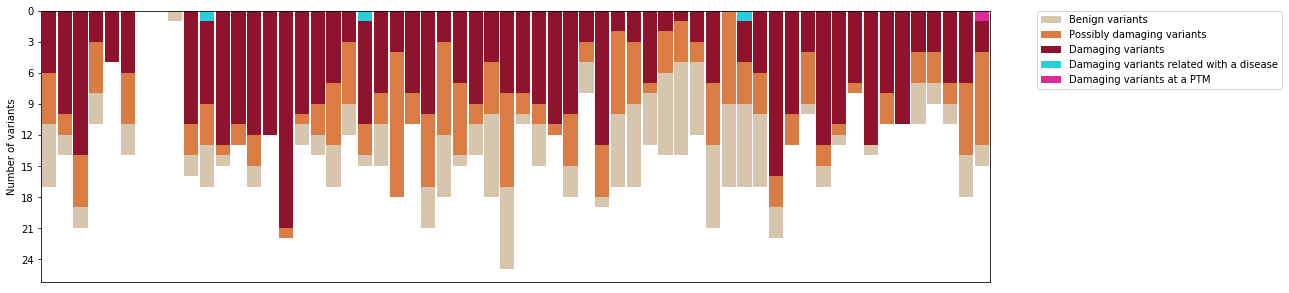

In [121]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_ibspos_total_amin,inner_binding_site_gnum,True,True, False, False,True)
#amin/vertical.png

Remember that the orange MVs are added meaning that the lenght of the orange bar is the number of possibly damaging variants. However, the blue MVs related with diseases, that have score 2 are overlapped to the variants with score 2, so in 34x50, there are 3 possibly damaging, 7 damaging and, among them one is related with a disease. 

## 5. Clustering
### 5.1 Clustering Class A, heatmap and horizontal sum

In [107]:
gpcr_ibspos=anls.cluster_df(gpcr_ibspos)
gpcr_ibspos_count=dict(zip(all_gpcrs_axes,[0]*len(all_gpcrs_axes)))
gpcr_ibspos_count_df=pd.DataFrame(list(gpcr_ibspos_count.items()),
                      columns=['GPCR','Count'])
# build dictionaries and df with only damaging:
(gpcr_ibspos_count_damaging_df,df_damaging)=anls.get_count_data(2,gpcr_ibspos)#damaging
# and only possibly damaging and damaging
(gpcr_ibspos_count_all_df,df_all)=anls.get_count_data(1,gpcr_ibspos)# possibly damaging and damaging

sorter=gpcr_ibspos.index
gpcr_ibspos_count_df=anls.order_df_by_sorterlist(sorter,gpcr_ibspos_count_df)
gpcr_ibspos_count_all_df=anls.order_df_by_sorterlist(sorter,gpcr_ibspos_count_all_df)
gpcr_ibspos_count_damaging_df=anls.order_df_by_sorterlist(sorter,gpcr_ibspos_count_damaging_df)

# visualize the clustered heatmap and horizontal barplots without dis, ptm info
# anls.heatmap_only(gpcr_ibspos)
# anls.heatmap_total_horizontal_sum_mixed_cluster(gpcr_ibspos)

['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A']


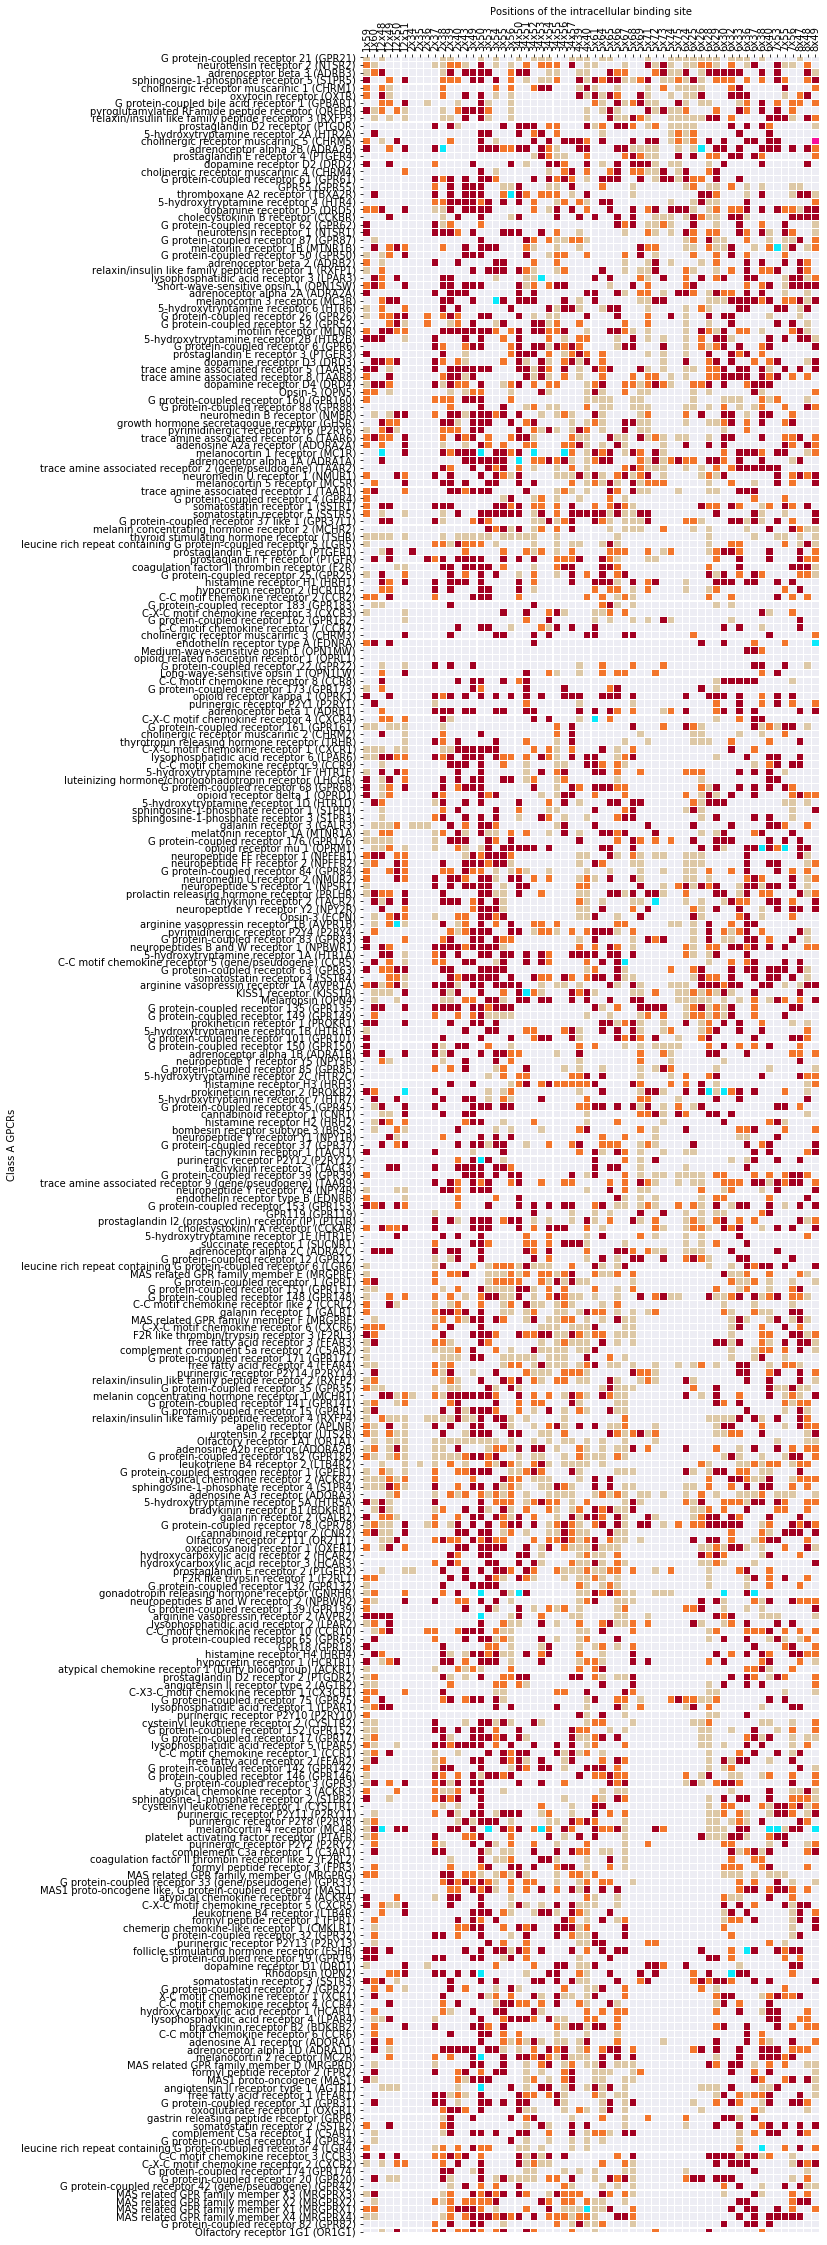

In [33]:
# build new dataframe clusterized and with dis/ptm info
gpcr_ibspos_total_clus=pd.DataFrame(index=gpcr_ibspos.index, columns=gpcr_ibspos.columns).fillna(value=0)
colorsToHeatmap=anls.fill_in_dataFrame_total(gpcr_ibspos_total_clus,gpcr_ibspos,gpcr_ibspos_dis,gpcr_ibspos_ptm,inner_binding_site_gnum)
anls.heatmap_only_total(gpcr_ibspos_total_clus,'Positions of the intracellular binding site',"Class A GPCRs", colorsToHeatmap)

# classA/heatmap.png

We can see there is an important hotspot for damaging variants from position 2x37 to 3x55. And, specially, position 3x50, also Ionic Lock, is a very hitted position.

In [34]:
# horizontal barplot class A clusterized
# old, no se si esta bien como la de abajo
# anls.heatmap_total_horizontal_sum_mixed_cluster(gpcr_ibspos_total_clus,False,True,False,True)#non-small, PTMs(pink), NO PTM+Dis(black), legend out

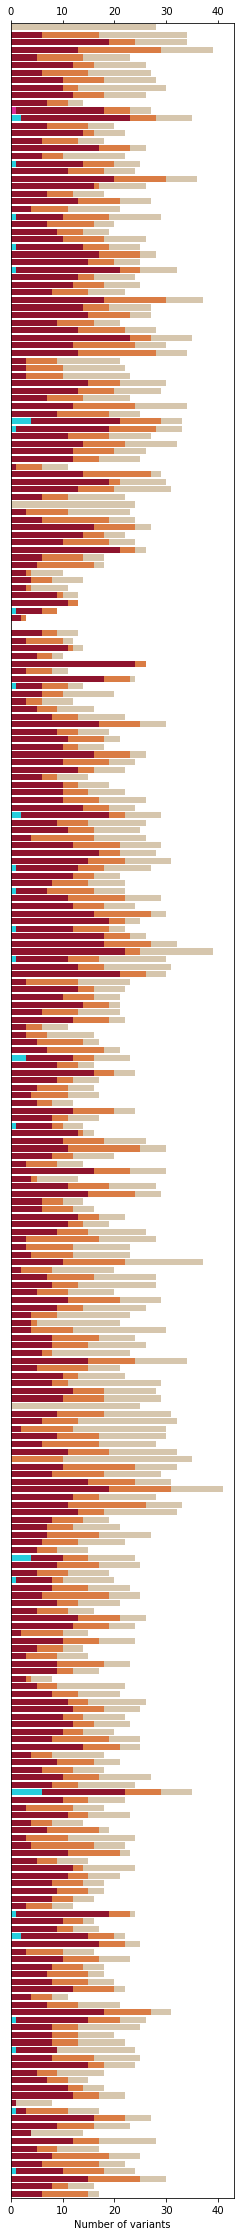

In [35]:
# horizontal barplot class A clusterized  
def get_counts(dataFrame, varType, yaxes=all_gpcrs_axes):
    ''' Build a dictionary and a data frame with the values that are in the 'range'
    of the corresponding varType, coming from the orignal dataframe'''
    # select the correct scores for each varType
    scores={'benign':[0,1,2,4,5,6],'posDam':[1,2,4,5,6],'dam':[2,4,5,6], 'disPTMjoin':[4,5,6], 'PTMjoin':[5,6], 'join':[6]}
    myList=scores[varType]
    #build dict with values as 0
    gpcr_pos_count_sel=dict(zip(yaxes,[0]*len(yaxes)))
    for gpcridx in gpcr_pos_count_sel.keys():# iterate over the GPCR names
        # count how many times the cells has a valueof the correct list 
        count=len([varval for varval in dataFrame.loc[gpcridx].values if varval in myList])
        gpcr_pos_count_sel[gpcridx]=count
        
    #build new data frame
    gpcr_pos_count_sel_df=pd.DataFrame(list(gpcr_pos_count_sel.items()),
                          columns=['GPCR','Count'])

    df_sel=pd.DataFrame.from_dict(gpcr_pos_count_sel,orient="index").T
    return (gpcr_pos_count_sel_df,df_sel)

def heatmap_total_horizontal_sum_mixed_cluster(dataFrame, small=False, ptm=False, disPTM=False, legendOut=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    if not small:
        fig, ax = plt.subplots(figsize=(4,40))
    else: 
        fig, ax = plt.subplots(figsize=(6,11))
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    ax4=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    # PTM+Dis    
    if disPTM:
        ax6=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_ptm_df , x="Count",y="GPCR",color="#030303",label="Damaging variants disease related at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        ax2.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
#     if legendOut:
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     else:
#         plt.legend()
        
    axB.get_yaxis().set_visible(False) # not visible
    plt.show()
    return None

heatmap_total_horizontal_sum_mixed_cluster(gpcr_ibspos_total_clus,False,True,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#classA/horizontal.png

['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A']


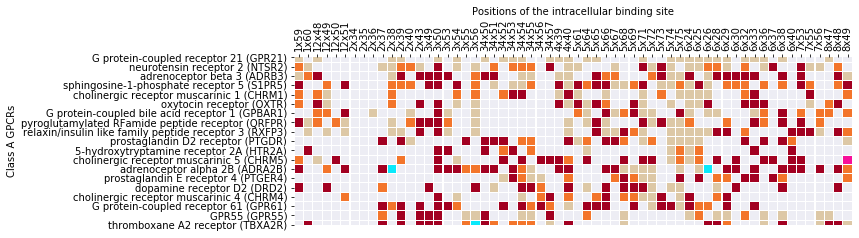

In [36]:
# Small part of the heatmap
gpcr_ibspos_total_clus_cut = pd.DataFrame(gpcr_ibspos_total_clus)[:19].copy(deep=True)

def heatmap_only_total_cut(dataFrame,colors,axisText,x=10,y=10):
    
    '''Plot the data frame than contains the info of the score, diseases and PTM'''    
    colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4"]
    if 'blue' in colors: # there are cells with 10
        colormap.append( "#09E9FB")
    if 'pink' in colors:# there are cells with 20
        colormap.append( "#F70F9A")
    if 'black' in colors: # there are cells with 30
        colormap.append( "#030303")
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm, dis-ptm
    # 0,      1,     2,    3,    4,   5,      6
    # pale, orange, red, white, blue, pink, black
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    ax.set(xlabel=axisText,ylabel='Class A GPCRs')    
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    return None
    
heatmap_only_total_cut(gpcr_ibspos_total_clus_cut, colorsToHeatmap, 'Positions of the intracellular binding site',10,10)
# classA/heatmapZoom.png

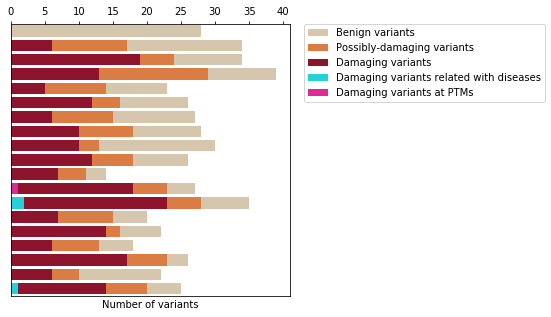

In [37]:
def heatmap_total_horizontal_sum_mixed_cluster_cut(dataFrame, x,y, small=False, dis=False, ptm=False, disPTM=False, legendOut=False, yText=False):
    ''' Build the horizontal barplot, sum for each GPCR, with the disease and PTM info.
    Add True as 2nd parameter if the heatmap will be for only aminergic (smaller df).
    Add True as 3rd parameter if there are ptm values to be displayed (pink).
    Add True as 4th parameter if there are Dis + ptm values to be displayed (black).
    Add True as 5th parameter if you want the legend out of the plot
    dd True as 6th parameter if you want to hide the ylabels'''
    # build dictionaries and df with only damaging:
    rows=list(dataFrame.index.values)
    (gpcr_ibspos_count_ben_df,df_ben)=anls.get_counts(dataFrame,'benign',rows)#bening
    (gpcr_ibspos_count_damaging_df,df_damaging)=anls.get_counts(dataFrame,'dam',rows)#damaging
    # and only possibly damaging and damaging
    (gpcr_ibspos_count_all_df,df_all)=anls.get_counts(dataFrame,'posDam',rows)# possibly damaging and damaging
    
    # dam+dis
    (gpcr_ibspos_count_dis_df,df_dis)=anls.get_counts(dataFrame,'disPTMjoin',rows)#damaging+disease
    # dam+ptm
    (gpcr_ibspos_count_ptm_df,df_ptm)=anls.get_counts(dataFrame,'PTMjoin',rows)#damaging+ptm
    # dam+dis+ptm
    (gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)=anls.get_counts(dataFrame,'join',rows)#damaging+dis+ptm

    abundance_dist_damaging_df=anls.get_count_dist(gpcr_ibspos_count_damaging_df,df_damaging)
    abundance_dist_all_df=anls.get_count_dist(gpcr_ibspos_count_all_df,df_all)
    abundance_dist_bening_df=anls.get_count_dist(gpcr_ibspos_count_ben_df,df_ben)
    
    abundance_dist_dis_df=anls.get_count_dist(gpcr_ibspos_count_dis_df,df_dis)
    abundance_dist_ptm_df=anls.get_count_dist(gpcr_ibspos_count_ptm_df,df_ptm)
    abundance_dist_dis_ptm_df=anls.get_count_dist(gpcr_ibspos_count_dis_ptm_df,df_dis_ptm)
    
    #reprentation of both dataframes in a barplot
    grid = plt.GridSpec(1, 1)
    fig, ax = plt.subplots(figsize=(x,y)) 
    #benign
    ax1=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_ben_df , x="Count",y="GPCR",color="#DDC8A6",label="Benign variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    if not yText:
        axB.get_yaxis().set_visible(False) # not visible
        
    # pos dam
    ax2=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#F3752B",label="Possibly-damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
        
    # dam
    ax3=plt.subplot(grid[0, 0])
    axB = sns.barplot(data=gpcr_ibspos_count_damaging_df , x="Count",y="GPCR",color="#A20021",label="Damaging variants")
    axB.get_yaxis()
    axB.xaxis.set_label_text("Number of variants")
    axB.xaxis.set_ticks_position('top')
    #axB.xaxis.set_label_position('top') 
    if small: 
        anls.change_width_h(axB, 0.9)
    # dis
    if dis:
        ax4=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_dis_df , x="Count",y="GPCR",color="#09E9FB",label="Damaging variants related with diseases")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)
    
    # PTM
    if ptm:
        ax5=plt.subplot(grid[0, 0])
        axB = sns.barplot(data=gpcr_ibspos_count_ptm_df , x="Count",y="GPCR",color="#F70F9A",label="Damaging variants at PTMs")
        axB.get_yaxis()
        axB.xaxis.set_label_text("Number of variants")
        axB.xaxis.set_ticks_position('top')
        #axB.xaxis.set_label_position('top') 
        if small: 
            anls.change_width_h(axB, 0.9)


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    return None
heatmap_total_horizontal_sum_mixed_cluster_cut(gpcr_ibspos_total_clus_cut,5,5,False,True,True,True)#non-small, PTMs(pink), PTM+Dis(black), legend out
#classA/horizontalZoom.png

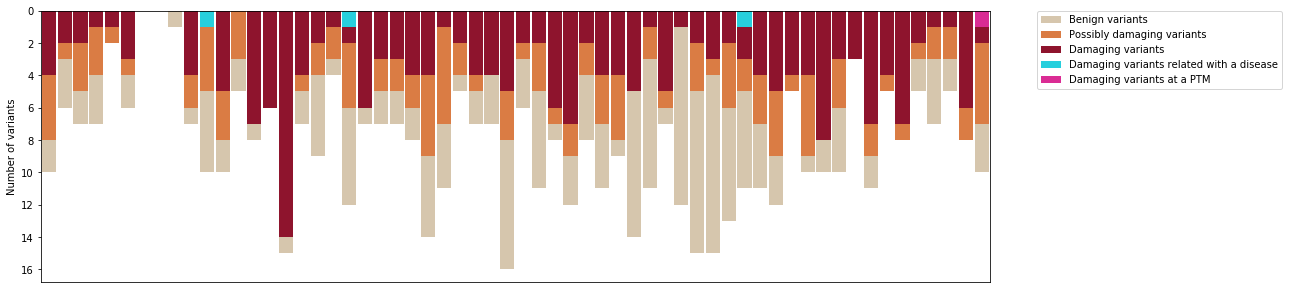

In [38]:
anls.heatmap_vert_sum_mixed_total_allColors(gpcr_ibspos_total_clus_cut,inner_binding_site_gnum,True,True, False, False, True) # legendOut, downwards, notBlue
#classA/verticalZoom.png

### 5.2  Clustering Aminergic, heatmap and horizontal sum

In [117]:
gpcr_ibspos_total_amin_clus=anls.cluster_df(gpcr_ibspos_total_amin)#cluster the dataframe

rows=list(gpcr_ibspos_total_amin_clus.index.values)
gpcr_ibspos_count_amin=dict(zip(aminergicLong,[0]*len(aminergicLong)))
gpcr_ibspos_count_amin_df=pd.DataFrame(list(gpcr_ibspos_count_amin.items()),
                      columns=['GPCR','Count'])

# I think this block is not needed here :

# # build dictionaries and df with only damaging:
# (gpcr_ibspos_count_amin_damaging_df,df_amin_damaging)=anls.get_count_data(2,gpcr_ibspos_total_amin,rows)#damaging
# # and only possibly damaging and damaging
# (gpcr_ibspos_count_amin_all_df,df_amin_all)=anls.get_count_data(1,gpcr_ibspos_total_amin,rows)# possibly damaging and damaging

# # disease + ptm
# (gpcr_ibspos_count_amin_dis_df,df_amin_dis)=get_count_data_damaging(4,gpcr_ibspos_total_amin,rows)#damaging+dis
# (gpcr_ibspos_count_amin_ptm_df,df_amin_ptm)=get_count_data_damaging(5,gpcr_ibspos_total_amin,rows)#damaging+ptm
# (gpcr_ibspos_count_amin_dis_ptm_df,df_amin_ptm_dis)=get_count_data_damaging(6,gpcr_ibspos_total_amin,rows)#damaging+ptm+dis


# sorter=gpcr_ibspos_total_amin.index
# gpcr_ibspos_count_amin_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_df)
# gpcr_ibspos_count_amin_all_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_all_df)
# gpcr_ibspos_count_amin_damaging_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_damaging_df)
# gpcr_ibspos_count_amin_dis_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_amin_dis_df)
# gpcr_ibspos_count_amin_ptm_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_amin_ptm_df)
# gpcr_ibspos_count_amin_dis_ptm_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_amin_dis_ptm_df)


In [122]:
# gpcr_ibspos_total_amin_clus

Benign: #DDC8A6 -> crudo
Pos Dam: #F3752B -> Orange
Dam: #A20021 -> Red
No data: #EDEDF4 -> white
Dam + Dis: #09E9FB -> blue
Dam + PTM: #F70F9A -> pink
['#DDC8A6', '#F3752B', '#A20021', '#EDEDF4', '#09E9FB', '#F70F9A']
False


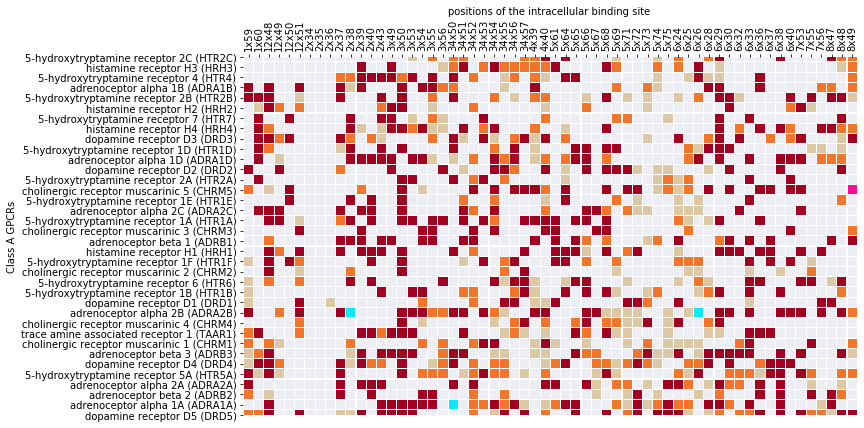

In [120]:
def heatmap_only_total_IBS(dataFrame,colors,listGnum,x=40,y=40,amin=False,):
    '''Plot the data frame than contains the info of the score, diseases and PTM.
    Add True to change the y axis label to aminergic'''    
    colormap=["#DDC8A6","#F3752B","#A20021", "#EDEDF4","#09E9FB","#F70F9A"]
    print("Benign: #DDC8A6 -> crudo")
    print("Pos Dam: #F3752B -> Orange")
    print("Dam: #A20021 -> Red")
    print("No data: #EDEDF4 -> white")
    print("Dam + Dis: #09E9FB -> blue")
    print("Dam + PTM: #F70F9A -> pink")
    
    print(colormap)
    fig, ax = plt.subplots(figsize=(x,y))
    # bening, poss, dam,nodata, dis,   ptm
    # 0,      1,     2,    3,    4,   5,      
    # pale, orange, red, white, blue, pink
    ax2=sns.heatmap(dataFrame, cmap=colormap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
    ax2.xaxis.set_ticks_position('top')
    axisText=anls.defineRegion(listGnum)
    print(amin)
    if amin:
        ax.set(xlabel=axisText, ylabel='Aminergic GPCRs')
    else: 
        ax.set(xlabel=axisText,ylabel='Class A GPCRs')
    
    ax2.xaxis.set_label_position('top')
    plt.xticks(rotation=90) 
    plt.show()
    return None

heatmap_only_total_IBS(gpcr_ibspos_total_amin_clus, colorsToHeatmap, inner_binding_site_gnum,11,11)

#amin/heatmap.png

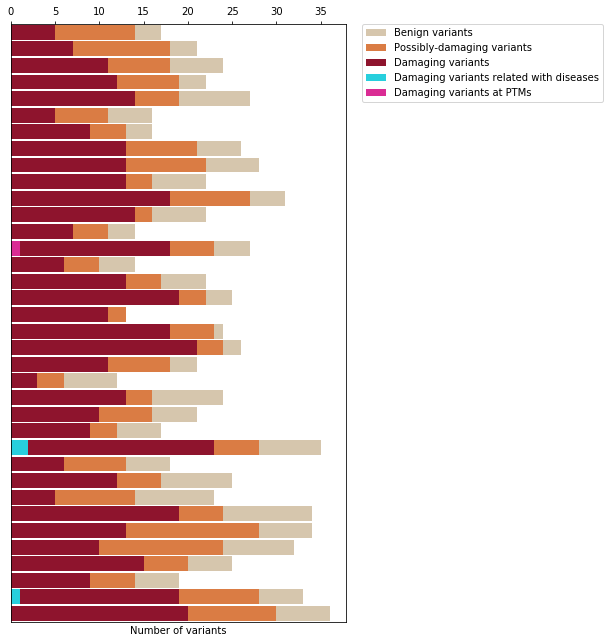

In [128]:
# horizontal barplot
anls.heatmap_total_horizontal_sum_mixed_cluster(gpcr_ibspos_total_amin_clus, True, True, True, False,True)#small, Dis(blue), PTMs(pink), NO PTM+Dis(black), legend out
# amin/horizontal.png

# Mapping
Now we will map in a template, an aminergic GPCR, the variants colored by frequency.
+ Positions 'more porbably damaged when mutated' with more score '2' (and '1'). 
+ Positions 'more ralated with diseases', colored by number of related diseases/number of different variants.
+ Positions related with PTMs (none in this region).
+ Positions 'more interesting positions', the ones that have score 2 and are related with diseases/PTMs, for class A and aminergic.

In [44]:
def min_max_freqs_percentage(freqMin, freqMax):
    '''Compute the min and max frequencies in % in a list, min and max'''
    values=[]
    values.append(freqMin*100/len(all_gpcrs_axes))
    values.append(freqMax*100/len(all_gpcrs_axes))
    return values

def create_reps_colormap(gpcr,pdbName,pdbPath,vars_display,colorPalette='YlOrRd',rep_chains=False, ptm=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs.
    norm is used to spread the freq values for all the 61 colors, otherwise not all the color scale
    may be reached'''
     
    pdb=pdbName
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
        
    color_dic={}
    freq_set=set()
    for element in vars_display:
        freq_set.add(element['value'])
    freq_unique_sorted=list(freq_set)
    freq_unique_sorted.sort()
    norm_colors=[]
    
    if colorPalette=='Blues':
        color_map_long=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)+10).as_hex()
        color_map=color_map_long[10:]
        color_map.insert(0,'#ffffff')
    elif colorPalette=='RdPu': 
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
        color_map.insert(0,'#ffffff')
    else:
        color_map=sns.color_palette(colorPalette,n_colors=len(freq_unique_sorted)).as_hex()
    if ptm:
#         print(color_map)
        color_map=['#ffffff',"#f977ca"]
    print('Frequencies:',freq_unique_sorted)
#     print(color_map)
    print('The min and max values of the frequencies in percentage:')
    print(min_max_freqs_percentage(freq_unique_sorted[0],freq_unique_sorted[-1]))#min and max in %
    
    for i in range(0,len(freq_unique_sorted)):# build dictionary frequency:color
        color_dic[freq_unique_sorted[i]]=color_map[i]    
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein and chain A and resid < 1000"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdbPath,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
#     mol.reps.add(sel=gpcr_sel,style='VDW')

    for var in vars_display:
#         print(var['value'], color_dic[var['value']])
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_dic[var['value']],style='VDW')
    mol.center()
    mol.camera = 'orthographic'
    #mol.view()
    return mol

### 1. Positions more porbably damaged when mutated

In [45]:
# return a dictionary with the position and frequency: score_freq_dict
# score 2:
score_freq_dict=anls.freq_score_dic(gpcr_ibspos,inner_binding_site_gnum,2)
# score 1:
score_freq_dict_1=anls.freq_score_dic(gpcr_ibspos,inner_binding_site_gnum,1)
# score 0:
score_freq_dict_0=anls.freq_score_dic(gpcr_ibspos,inner_binding_site_gnum,0)
# score 3:
score_freq_dict_3=anls.freq_score_dic(gpcr_ibspos,inner_binding_site_gnum,3)

In [46]:
# % of cells in the heatmap that have score:

anls.percentage_cells(all_gpcrs_axes,score_freq_dict,2)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_1,1)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_0,0)
anls.percentage_cells(all_gpcrs_axes,score_freq_dict_3,3)

The 15.963995354239257 % of the cells have score 2
The 10.29616724738676 % of the cells have score 1
The 12.142857142857142 % of the cells have score 0
The 61.59698025551684 % of the cells have score 3


The number of cells is the number of GPCRs (rows, in this case class A) multiplied by the number of positions that form the IBS.

In [47]:
gpcr="HTR2A" # Template, 5-hydroxytryptamine receptor 2A, drug target, aminergic
pdbname="6A94" # inactive structure
pdb_path=os.path.join(path_to_project,"Data/pdb_files/")
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=anls.gpcr_pdb_dict_fom_json(dictpath+json_filename)
# score 2
vars_display=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict.items():
    score_var_info={}
    if gnum in gpcr_pdb:
        score_var_info["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info["value"]=freq
        vars_display.append(score_var_info)
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [16, 21, 25, 27, 28, 32, 34, 36, 38, 39, 41, 42, 44, 45, 46, 48, 49, 56, 57, 60, 61, 62, 63, 65, 67, 68, 70, 72, 80, 81, 82, 89, 111, 171]
The min and max values of the frequencies in percentage:
[5.574912891986063, 59.58188153310105]


_ColormakerRegistry()

NGLWidget()

In more redish colors we have the possitions that have shown more times a variant with score 2. We can see that the inner part possitions are the ones that are more times tagged as damaging (more yellowish in the internal residues).

In [48]:
# score 1

vars_display_1=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_1.items():
    score_var_info_1={}
    if gnum in gpcr_pdb:
        score_var_info_1["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_1["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_1["value"]=freq
        vars_display_1.append(score_var_info_1)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_1, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [5, 15, 17, 18, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 54]
The min and max values of the frequencies in percentage:
[1.7421602787456445, 18.81533101045296]


NGLWidget()

In [49]:
# score 0

vars_display_0=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in score_freq_dict_0.items():
    score_var_info_0={}
    if gnum in gpcr_pdb:
        score_var_info_0["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_0["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_0["value"]=freq
        vars_display_0.append(score_var_info_0)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_0, 'Reds')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [7, 8, 13, 14, 17, 19, 20, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 46, 48, 51, 52, 55, 59, 61, 62, 63, 72, 77, 90]
The min and max values of the frequencies in percentage:
[2.4390243902439024, 31.358885017421603]


NGLWidget()

On the other hand, for the score 1 variants, possibly damaging, they are more in the external parts (more yellowish in the external residues).

### 2. Positions more ralated with diseases
#### 2.1 Colored by number of related diseases

In [50]:
relDiseases_freq_dict=anls.freq_disease_dic(gpcr_ibspos_dis, inner_binding_site_gnum)
relDiseases_freq_dict

{'1x59': 68,
 '1x60': 4,
 '12x48': 12,
 '12x49': 16,
 '12x50': 2,
 '12x51': 5,
 '2x34': 0,
 '2x35': 0,
 '2x36': 0,
 '2x37': 0,
 '2x38': 1,
 '2x39': 0,
 '2x40': 8,
 '2x43': 6,
 '3x49': 0,
 '3x50': 12,
 '3x53': 1,
 '3x54': 4,
 '3x55': 1,
 '3x56': 3,
 '34x50': 2,
 '34x51': 6,
 '34x52': 38,
 '34x53': 2,
 '34x54': 0,
 '34x55': 2,
 '34x56': 3,
 '34x57': 3,
 '4x39': 4,
 '4x40': 4,
 '5x61': 2,
 '5x64': 1,
 '5x65': 5,
 '5x66': 1,
 '5x67': 1,
 '5x68': 1,
 '5x69': 0,
 '5x71': 0,
 '5x72': 2,
 '5x73': 3,
 '5x74': 0,
 '5x75': 0,
 '6x24': 0,
 '6x25': 1,
 '6x26': 6,
 '6x28': 9,
 '6x29': 1,
 '6x30': 8,
 '6x32': 2,
 '6x33': 0,
 '6x36': 1,
 '6x37': 1,
 '6x38': 3,
 '6x40': 4,
 '7x53': 2,
 '7x55': 9,
 '7x56': 1,
 '8x47': 1,
 '8x48': 0,
 '8x49': 7}

In [58]:
# Related diseases of variants in each position
vars_display_relDis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in relDiseases_freq_dict.items():
    score_var_info_relDis={}
    if gnum in gpcr_pdb:
        score_var_info_relDis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_relDis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_relDis["value"]=freq
        vars_display_relDis.append(score_var_info_relDis)

vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_relDis,'Blues')
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 38, 68]
The min and max values of the frequencies in percentage:
[0.0, 23.693379790940767]


NGLWidget()

#### 2.2 Colored by number of different variants
In here we will just consider the variants related with diseases that are also score 2.

In [52]:
disDamaging_freq_dict=anls.freq_score_dic(gpcr_ibspos_total_clus,inner_binding_site_gnum,4)
# disDamaging_freq_dict
anls.percentage_cells(all_gpcrs_axes,disDamaging_freq_dict,4)

The 0.2380952380952381 % of the cells have score 4


In [53]:
# score 4, dis+damaging
vars_display_dis=[]# list containing dictionaries with the position, chain and freq of variants
for gnum, freq in disDamaging_freq_dict.items():
    score_var_info_dis={}
    if gnum in gpcr_pdb:
        score_var_info_dis["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        score_var_info_dis["chain"]=gpcr_pdb[gnum]["chain"]
        score_var_info_dis["value"]=freq
        vars_display_dis.append(score_var_info_dis)
# from green to redish, normalized
create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_dis).view()

Frequencies: [0, 1, 2, 7]
The min and max values of the frequencies in percentage:
[0.0, 2.4390243902439024]


NGLWidget()

The more yellowish variants are the ones that are more times tagged as damaging and related with at least one disease. The majority of those variants that have score 4 (damaging+disease  related) just appear one time for a determined position, although we can see some that are more yellow-orange, so a damaging+disRelated variant that has appear more than one time in that position.

### 2.3 Variants affecting PTMs
There are not PTMs in the intracellular regions.

### 4. Positions 'more interesting' to simulate 
The ones that have score 2 and are related with diseases/PTMs in the aminergic family. In this case there is only one position related with diseases, for the ADRA1A (the majority of alpha-1 receptors are directed toward the function of epinephrine, a hormone that has to do with the fight-or-flight response) position 34x50:

In [54]:
score_var_info_ptm={'pdb_pos': '386', 'chain': 'A', 'value': 1}

In [55]:

vars_display_ptm=[{'pdb_pos': '101', 'chain': 'A', 'value': 0},
 {'pdb_pos': '102', 'chain': 'A', 'value': 0},
 {'pdb_pos': '103', 'chain': 'A', 'value': 0},
 {'pdb_pos': '104', 'chain': 'A', 'value': 0},
 {'pdb_pos': '105', 'chain': 'A', 'value': 0},
 {'pdb_pos': '106', 'chain': 'A', 'value': 0},
 {'pdb_pos': '107', 'chain': 'A', 'value': 0},
 {'pdb_pos': '108', 'chain': 'A', 'value': 0},
 {'pdb_pos': '109', 'chain': 'A', 'value': 0},
 {'pdb_pos': '110', 'chain': 'A', 'value': 0},
 {'pdb_pos': '113', 'chain': 'A', 'value': 0},
 {'pdb_pos': '172', 'chain': 'A', 'value': 0},
 {'pdb_pos': '173', 'chain': 'A', 'value': 0},
 {'pdb_pos': '176', 'chain': 'A', 'value': 0},
 {'pdb_pos': '177', 'chain': 'A', 'value': 0},
 {'pdb_pos': '178', 'chain': 'A', 'value': 0},
 {'pdb_pos': '179', 'chain': 'A', 'value': 0},
 {'pdb_pos': '180', 'chain': 'A', 'value': 0},
 {'pdb_pos': '181', 'chain': 'A', 'value': 0},
 {'pdb_pos': '182', 'chain': 'A', 'value': 0},
 {'pdb_pos': '183', 'chain': 'A', 'value': 0},
 {'pdb_pos': '184', 'chain': 'A', 'value': 0},
 {'pdb_pos': '185', 'chain': 'A', 'value': 0},
 {'pdb_pos': '186', 'chain': 'A', 'value': 0},
 {'pdb_pos': '187', 'chain': 'A', 'value': 0},
 {'pdb_pos': '189', 'chain': 'A', 'value': 0},
 {'pdb_pos': '190', 'chain': 'A', 'value': 0},
 {'pdb_pos': '257', 'chain': 'A', 'value': 0},
 {'pdb_pos': '260', 'chain': 'A', 'value': 0},
 {'pdb_pos': '261', 'chain': 'A', 'value': 0},
 {'pdb_pos': '262', 'chain': 'A', 'value': 0},
 {'pdb_pos': '263', 'chain': 'A', 'value': 0},
 {'pdb_pos': '264', 'chain': 'A', 'value': 0},
 {'pdb_pos': '265', 'chain': 'A', 'value': 50},
 {'pdb_pos': '313', 'chain': 'A', 'value': 0},
 {'pdb_pos': '314', 'chain': 'A', 'value': 0},
 {'pdb_pos': '316', 'chain': 'A', 'value': 0},
 {'pdb_pos': '317', 'chain': 'A', 'value': 0},
 {'pdb_pos': '318', 'chain': 'A', 'value': 0},
 {'pdb_pos': '320', 'chain': 'A', 'value': 0},
 {'pdb_pos': '321', 'chain': 'A', 'value': 0},
 {'pdb_pos': '324', 'chain': 'A', 'value': 0},
 {'pdb_pos': '325', 'chain': 'A', 'value': 0},
 {'pdb_pos': '326', 'chain': 'A', 'value': 0},
 {'pdb_pos': '328', 'chain': 'A', 'value': 0},
 {'pdb_pos': '380', 'chain': 'A', 'value': 0},
 {'pdb_pos': '382', 'chain': 'A', 'value': 0},
 {'pdb_pos': '383', 'chain': 'A', 'value': 0},
 {'pdb_pos': '384', 'chain': 'A', 'value': 0},
 {'pdb_pos': '385', 'chain': 'A', 'value': 0},
 {'pdb_pos': '386', 'chain': 'A', 'value': 50}]
vieww=create_reps_colormap(gpcr,pdbname,pdb_path,vars_display_ptm,'RdPu', False, True)
vieww.camera = 'orthographic'
vieww.view()

Frequencies: [0, 50]
The min and max values of the frequencies in percentage:
[0.0, 17.421602787456447]


NGLWidget()

Info of the variant, in ICL2, P -> Q, allele info (1,3,18E-05,31406):
+ Related with Hypogonadism, Isolated Hypogonadotropic, C3489396, score 0.01 (deficiency in or insensitivity to gonadotropin-releasing hormone (GnRH) where the function and anatomy of the anterior pituitary is otherwise normal. Teduced or absent puberty, low libido, infertility, etc. due to an impaired release of the gonadotropins, follicle-stimulating hormone and luteinizing hormone, and a resultant lack of sex steroid and peptides production by the gonads.).
+ Impact Score 2: 
+ + PolyPhen2: ENST00000276393:0.998   ENST00000354550:0.993   ENST00000380572:0.993   ENST00000380573:0.998   ENST00000380582:1   ENST00000380586:0.999   ENST00000519096:0.993   ENST00000519229:0.996   ENST00000521711:0.993
+ + SIFT: ENST00000276393:0   ENST00000354550:0   ENST00000380572:0   ENST00000380573:0   ENST00000380582:0   ENST00000380586:0   ENST00000519096:0   ENST00000519229:0   ENST00000521711:0

The thing is that Hypogonadism is not a mental illnes so we do not consider this as an important variant. We will consider other positions highly hitted as damaging. The variants are not responsible for any diseases but they may be important for other things as the response to some mental illnes treatment. So we can choose 3x50 and select a GPCR that presents a variant in that position (damaging and 'changed') and is a mental illness drug target. 


In [56]:
totalDis=0
for key, value in relDiseases_freq_dict.items():
    totalDis+=relDiseases_freq_dict[key]
print('Total diseases',totalDis)

totalDisDam=0
for key, value in disDamaging_freq_dict.items():
    totalDisDam+=disDamaging_freq_dict[key]
print('Total diseases damaging',totalDisDam)

Total diseases 279
Total diseases damaging 41
